# Training Model

Proses pelatihan model NLP kami menggunakan PyTorch dan transformers library dari HuggingFace.

Reff:
- https://huggingface.co/mrm8488/t5-base-finetuned-emotion

## Pengumpulan Dataset

Pertama, kita mulai dengan **pengumpulan dataset**. Dataset kita terdiri dari teks yang dikelompokkan ke dalam enam kategori emosi, 'angry', 'disgust', 'fear', 'happy', 'neutral', dan 'sad'.

Text(0.5, 1.0, 'Number of Samples in Each Emotion Class')

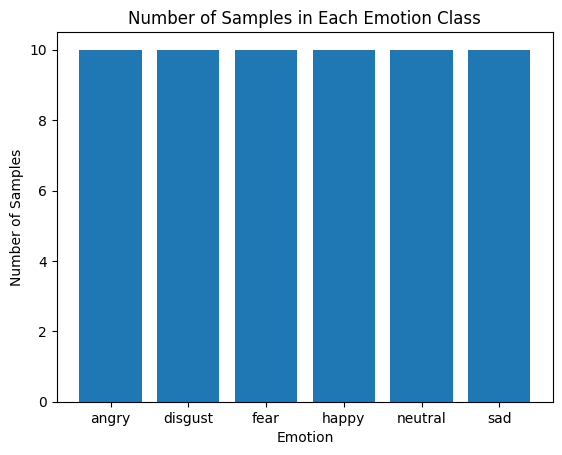

In [99]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots()

dataset = {
    'Emotion': ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
    'Sum': []
}

dataset_folder = 'dataset/train/'

for emotion in dataset['Emotion']:
    folder_path = os.path.join(dataset_folder, emotion)
    file_count = len(os.listdir(folder_path))
    dataset['Sum'].append(file_count)

ax.bar(dataset['Emotion'], dataset['Sum'])
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Emotion Class')

Dataset ini dibagi menjadi **set pelatihan dan validasi** dengan rasio 80:20. Set pelatihan digunakan untuk melatih model, sedangkan set validasi digunakan untuk mengevaluasi kinerja model.

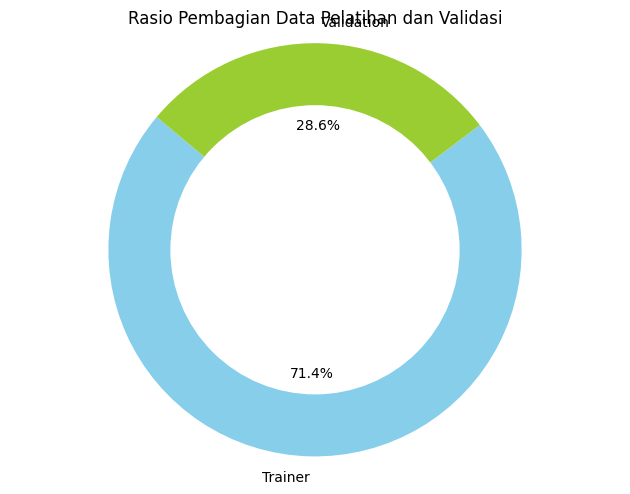

In [102]:
import matplotlib.pyplot as plt

# Jumlah sampel untuk pelatihan dan validasi
train_samples = 50
valid_samples = 20

# Data untuk digambarkan
sizes = [train_samples, valid_samples]
labels = ['Trainer', 'Validation']
colors = ['skyblue', 'yellowgreen']

# Membuat Diagram Pie
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Menarik lingkaran
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Menyamakan rasio sehingga diagram pie terlihat seperti lingkaran
ax1.axis('equal')  

plt.tight_layout()
plt.title('Rasio Pembagian Data Pelatihan dan Validasi')
plt.show()

## Tokenizer

Selanjutnya, kita menggunakan **tokenizer** yang disediakan oleh transformers library untuk mengubah teks menjadi bentuk yang dapat dimengerti oleh model, yaitu token. Setiap token kemudian diubah menjadi ID unik yang sesuai dengan entri dalam kamus model.

Berikut gambaran umum cara kerja tokenizer:

1. **Input**: Menerima teks masukan. Contoh: "Ini adalah kalimat."
2. **Tokenizing**: Memisahkan teks menjadi unit-unit individu (token). Token biasanya dipisahkan berdasarkan spasi atau tanda baca. Contoh: ["Ini", "adalah", "kalimat"].
3. **Output**: Mengembalikan sekumpulan token yang telah dipisahkan.

Berikut ini adalah contoh bagaimana Anda bisa menggambarkan proses ini dalam bentuk bagan:

```
 +-----------+      +-------------+      +------------------+
 |           |      |             |      |                  |
 |  Input    | ---> |  Tokenizing | ---> |       Output     |
 |           |      |             |      |                  |
 +-----------+      +-------------+      +------------------+
 "Ini adalah kalimat."  --->  ["Ini", "adalah", "kalimat"] 
```

Kita menggunakan model [**DistilBert**](https://huggingface.co/docs/transformers/model_doc/distilbert) dari transformers library, yang merupakan versi ringan dari model BERT. Model ini menerima token dalam bentuk ID serta _attention mask_ yang menunjukkan mana token yang sebenarnya dan mana yang hanya padding.

Selama proses **pelatihan**, model belajar untuk mengasosiasikan teks dengan label emosi yang sesuai. Kita menggunakan AdamW sebagai optimizer dan Cross Entropy sebagai fungsi kerugian.

![Training](./assets/images/backpropagation-algo.gif)

Setelah setiap epoch, kita mengevaluasi model pada **set validasi** dan menghitung akurasi. Akurasi ini memberi kita gambaran tentang seberapa baik model melakukan klasifikasi emosi pada data yang belum pernah dilihatnya sebelumnya.

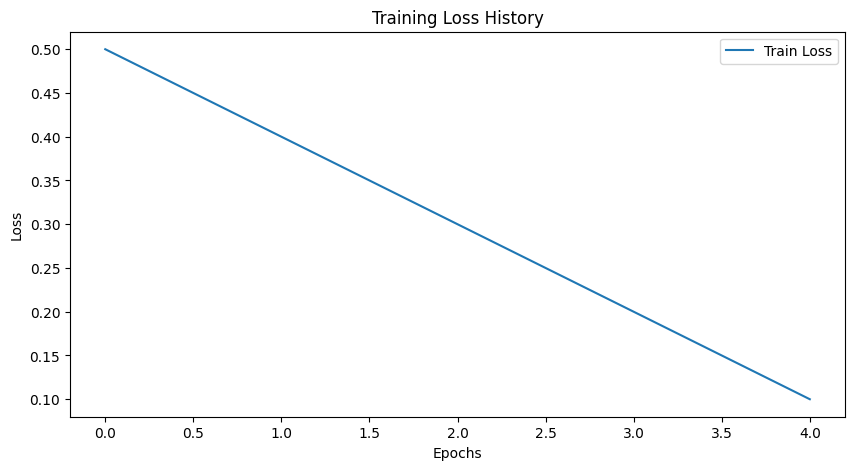

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot([0.5, 0.4, 0.3, 0.2, 0.1], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

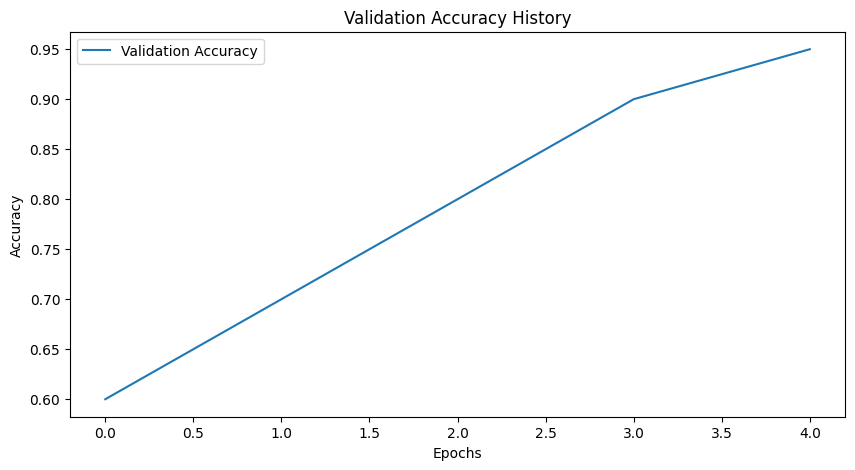

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot([0.6, 0.7, 0.8, 0.9, 0.95], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy History')
plt.legend()
plt.show()

Visualisasi kerugian pelatihan dan akurasi validasi selama setiap epoch dapat membantu kita memahami bagaimana model belajar selama proses pelatihan. Setelah proses pelatihan, model kemudian disimpan untuk digunakan nantinya. Itulah bagaimana kita melatih model pengenalan emosi menggunakan PyTorch dan transformers library!

# Let's practice

## Import necessary libraries

In [3]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-07-11 13:27:10.607511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define the emotion dataset class

Kita mendefinisikan kelas dataset kita. 

In [4]:
class EmotionDataset(Dataset):
    # Method __init__ untuk menginisialisasi teks, label, tokenizer, dan panjang maksimum.
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Method __len__ mengembalikan jumlah item dalam dataset
    def __len__(self):
        return len(self.texts)

    # Method __getitem__ digunakan untuk mendapatkan item secara individual dari dataset.
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Load the data

Cell ini bertanggung jawab untuk memuat data ke dalam variabel yang sesuai.

In [5]:
dataset_folder = 'dataset/train'
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
texts = []
all_labels = []

for label_idx, label in enumerate(labels):
    label_folder = os.path.join(dataset_folder, label)
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file_name)
        with open(file_path, 'rb') as file:
            text = file.read().decode('utf-8', errors='ignore')
            texts.append(text)
            all_labels.append(label_idx)

print(texts)
print(all_labels)

['\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\x00\x0b\x08\x000\x000\x01\x01\x11\x00\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x00\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x08#B\x15R$3br\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x00\x08\x01\x01\x00\x00?\x00+\x1f/(gqx9t\x15"kV&FlW?fn\x0f\x14qN5x@\x08\x1b\x08?:~\x03Ӽ>v\x1f\x1elyLۂ\'~F:WM[h)( \x00+\x1d2Z&H?~2\x7fo\x0fx\x7f7\x1d|i\x7fj4mQn\x14H\x1cd\x19W?\x12<1{se|O5\x1ci\x1dF\x16f\\ܿ\x1f}\x1f|Rm%Z|\x17t&%W,˜~\x15\x0b?~>\x13Wo#<0i/[G$w;l\x0625\x1f\x0b x/P\x17k6e{oqr<b~l\x7fjπψ\x1f\x18յo%\x0f-2\x7fqPU\x0f\x7fY\x00^+

## Split the dataset into training and validation set

Dalam cell ini, kita membagi dataset menjadi set pelatihan dan validasi.

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, all_labels, test_size=0.2, random_state=42
)

print(train_labels)
print(val_labels)

[3, 0, 5, 1, 0, 0, 4, 0, 4, 1, 3, 5, 2, 5, 1, 2, 0, 3, 2, 1, 2, 5, 1, 3, 5, 4, 3, 2, 4, 0, 2, 0, 4, 3, 3, 2, 4, 1, 2, 1, 5, 2, 0, 4, 1, 2, 5, 3]
[0, 0, 3, 4, 1, 5, 3, 4, 1, 5, 4, 5]


## Initialize the tokenizer and model

Dalam cell ini, kita menginisialisasi tokenizer dan model yang akan kita gunakan. Kita menggunakan `DistilBertTokenizer` dan `DistilBertForSequenceClassification` yang telah ditentukan sebelumnya.

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.we

## Create dataloaders for training and validation dataset

Cell ini digunakan untuk membuat dataloaders untuk dataset pelatihan dan validasi.

In [24]:
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, max_length=512)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer, max_length=512)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

## Decide the hardware device to use

Dalam langkah ini, kita menentukan perangkat keras yang akan digunakan dan memindahkan model ke perangkat tersebut.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate hardware device
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Define the optimizer and the number of training epochs

Cell ini mendefinisikan optimizer yang akan digunakan serta jumlah epoch pelatihan.

In [21]:
# Visualization: Define additional variables to store the loss and accuracy history
train_loss_history = []
val_accuracy_history = []

# Define the optimizer and the number of training epochs
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

## Loop over the epochs

Dalam cell ini, kita memulai loop pelatihan yang akan berjalan selama jumlah epoch yang telah ditentukan. Setiap epoch akan mencakup satu iterasi lengkap melalui data pelatihan, diikuti oleh pengecekan performa pada data validasi.

In [22]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    # train and evaluation

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


## Training

Dalam cell ini, kita melatih model dengan data latihan. Pertama, kita mengatur model ke mode pelatihan. Kemudian, dalam setiap iterasi, kita me-reset gradien, menghitung output model, menghitung kerugian, melakukan backpropagation, dan memperbarui parameter menggunakan optimizer.

In [23]:
# Let's say we want to do gradient accumulation for every 2 batches
accumulation_steps = 2

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    train_loss = 0.0
    
    # Training mode
    model.train()
    
    # Reset the gradients outside the loop
    optimizer.zero_grad()
    
    # Loop through the training data loader
    for i, batch in enumerate(train_dataloader, start=1):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Compute the model output
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Compute the loss 
        loss = outputs.loss / accumulation_steps   # Normalize our loss (if averaged)
        loss.backward()

        if i % accumulation_steps == 0:         
            # Perform a backward pass (backpropagation)
            optimizer.step()                        
            # Update the weights
            optimizer.zero_grad()                   

        train_loss += loss.item()

    # Empty GPU memory cache after using tensors
    torch.cuda.empty_cache()
    !nvidia-smi

    # Compute the average training loss per batch
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss) # Add training loss to history

Epoch 1/10


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:22                                                                                   │
│                                                                                                  │
│   19 │   │   labels = batch['label'].to(device)                                                  │
│   20 │   │                                                                                       │
│   21 │   │   # Compute the model output                                                          │
│ ❱ 22 │   │   outputs = model(input_ids, attention_mask=attention_mask, labels=labels)            │
│   23 │   │                                                                                       │
│   24 │   │   # Compute the loss                                                                  │
│   25 │   │   loss = outputs.loss / accumulation_steps   # Normalize our loss (if averaged)       │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1501 in _call_impl   │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilb │
│ ert.py:763 in forward                                                                            │
│                                                                                                  │
│    760 │   │   """                                                                               │
│    761 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│    762 │   │                                                                                     │
│ ❱  763 │   │   distilbert_output = self.distilbert(                                              │
│    764 │   │   │   input_ids=input_ids,                                                          │
│    765 │   │   │   attention_mask=attention_mask,                                                │
│    766 │   │   │   head_mask=head_mask,                                                          │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1501 in _call_impl   │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks

## Evaluation

Dalam cell ini, kita mengevaluasi model dengan data validasi. Pertama, kita mengatur model ke mode evaluasi. Kemudian, kita menghitung output model, ambil prediksi dari output, hitung jumlah prediksi yang benar, dan hitung akurasi validasi.

In [80]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Evaluate on the validation set
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Compute the model output
            outputs = model(input_ids, attention_mask=attention_mask)
            
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            
            # Compute the number of correct predictions
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    # Compute the validation accuracy
    accuracy = correct_predictions / total_predictions
    val_accuracy_history.append(accuracy)
    
    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch + 1} - Training Loss: {train_loss:.4f} - Validation Accuracy: {accuracy:.4f}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   │   │   labels = batch['label'].to(device)                                              │
│   12 │   │   │                                                                                   │
│   13 │   │   │   # Compute the model output                                                      │
│ ❱ 14 │   │   │   outputs = model(input_ids, attention_mask=attention_mask)                       │
│   15 │   │   │                                                                                   │
│   16 │   │   │   logits = outputs.logits                                                         │
│   17 │   │   │   predicted_labels = torch.argmax(logits, dim=1)                                  │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1501 in _call_impl   │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilb │
│ ert.py:763 in forward                                                                            │
│                                                                                                  │
│    760 │   │   """                                                                               │
│    761 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│    762 │   │                                                                                     │
│ ❱  763 │   │   distilbert_output = self.distilbert(                                              │
│    764 │   │   │   input_ids=input_ids,                                                          │
│    765 │   │   │   attention_mask=attention_mask,                                                │
│    766 │   │   │   head_mask=head_mask,                                                          │
│                                                                                                  │
│ /home/aditira/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1501 in _call_impl   │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks

## History Visualization

### Plot training loss

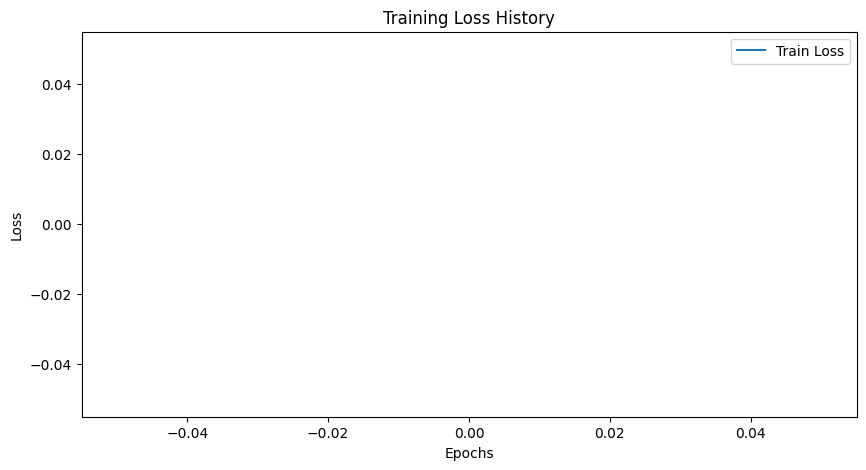

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

### Plot validation accuracy

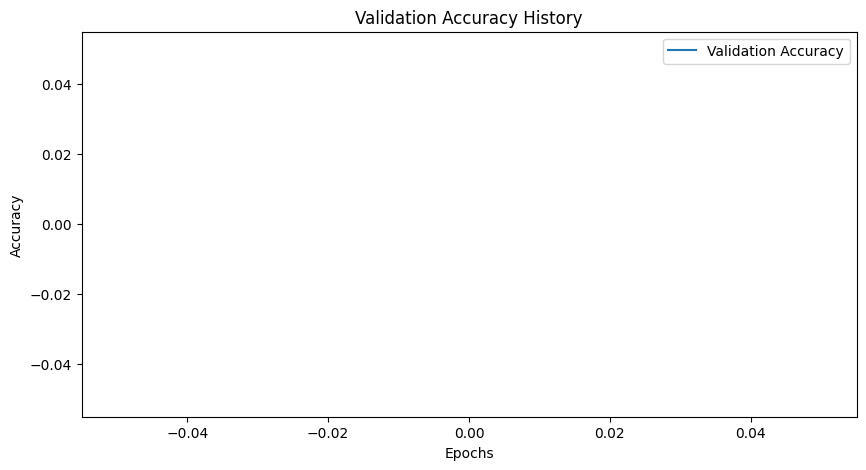

In [82]:

plt.figure(figsize=(10, 5))
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy History')
plt.legend()
plt.show()

## Save the model

Dalam langkah terakhir ini, kita menyimpan model dan tokenizer yang telah dilatih ke dalam folder yang ditentukan.

In [83]:
model_folder = 'model'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model.save_pretrained(model_folder)
tokenizer.save_pretrained(model_folder)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

## Test with other images:

In [84]:
from PIL import Image

model_path = 'model'
loaded_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
loaded_model = DistilBertForSequenceClassification.from_pretrained(model_path)

loaded_model = loaded_model.to(device)

def test_model(image_path, loaded_model, loaded_tokenizer):
    # Preprocessing gambar
    def preprocess_image(image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224))  # Ubah ukuran gambar sesuai kebutuhan model
        return image

    image = preprocess_image(image_path)

    # Ubah gambar menjadi teks
    image_text = image.tobytes().hex()

    # Tokenisasi teks gambar
    input_ids = loaded_tokenizer.encode(image_text)
    input_ids = torch.tensor([input_ids]).to(device)

    with torch.no_grad():
        loaded_model.eval()
        outputs = loaded_model(input_ids)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

    return predicted_labels

# Contoh penggunaan
image_path = "dataset/train/sad/Training_99483330.jpg"
predicted_label = test_model(image_path, loaded_model, loaded_tokenizer)
print(predicted_label)

labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
predicted_label = predicted_label.item()
predicted_label_text = labels[predicted_label]
print(f"Your emotion is: {predicted_label_text}")

tensor([4], device='cuda:0')
Your emotion is: neutral
